In [1]:
!pip install kaggle

In [3]:
!pip install pyspark

  Using cached pyspark-3.5.1.tar.gz (317.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=29bbb83886825d8cdcc7e27759b3c85aa9469f3e7bd12067e64321597aa5e30e
  Stored in directory: /Users/ezhuang/Library/Caches/pip/wheels/92/09/11/aa01d01a7f005fda8a66ad71d2be7f8aa341bddafb27eee3c7
Successfully built pyspark


In [3]:
!kaggle datasets download -d yelp-dataset/yelp-dataset

In [4]:
!unzip yelp-dataset.zip

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyspark.pandas as ps

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Yelp Data Analysis") \
    .config("spark.driver.memory", "64g") \
    .config("spark.executor.memory", "16g") \
    .config('spark.executor.instances', 6) \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/09 21:52:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
review_df = spark.read.json('yelp_academic_dataset_review.json')
business_df = spark.read.json('yelp_academic_dataset_business.json')
user_df = spark.read.json('yelp_academic_dataset_user.json') 

### We first want to read in the datasets we are planning on using into a spark dataframe.

#### These datasets will eventually be joined on the attributes user_id for review and user and on business_id for review and business. However we can first explore the datasets individually to first understand what they have and maybe see what can get lost in the joins.

### Taking a closer look at the review dataframe to understand missingness and text statistics

In [6]:
review_df.printSchema()
review_df.show(10)
print("Number of Reviews: " + str(review_df.count()))

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPp

Number of Reviews: 6990280


In [7]:
#looking for missing data wihtin the review section
from pyspark.sql.functions import col, count, when, length

missingdata_review = review_df.select([count(when(col(c).isNull(), c)).alias(c) for c in review_df.columns])
missingdata_review.show()


#looking for duplicates within the review section 
duplicate_review = review_df.groupby('text').count()\
    .where(col('count') >1).orderBy(col('count').desc())

duplicate_review.show()

+-----------+----+----+-----+---------+-----+----+------+-------+
|business_id|cool|date|funny|review_id|stars|text|useful|user_id|
+-----------+----+----+-----+---------+-----+----+------+-------+
|          0|   0|   0|    0|        0|    0|   0|     0|      0|
+-----------+----+----+-----+---------+-----+----+------+-------+



24/05/08 01:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/08 01:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/08 01:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/08 01:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/08 01:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/08 01:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/08 01:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/08 01:50:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/08 01:50:02 WARN RowBasedKeyValueBatch: Calling spill() on

+--------------------+-----+
|                text|count|
+--------------------+-----+
|DO NOT PARK HERE!...|   18|
|I had a terrible ...|   11|
|At the height of ...|   10|
|Your review helps...|   10|
|We had mistakenly...|   10|
|Great place to be...|    9|
|                   .|    9|
|We have been goin...|    8|
|My date and I tri...|    8|
|So they have poli...|    8|
|LIARS  LIARS  LIA...|    7|
|Omg!There's food ...|    7|
|I love Mexican re...|    7|
|I have been to th...|    7|
|The regretful fur...|    6|
|We have been comi...|    6|
|Normally I am ver...|    6|
|I am repeativitly...|    6|
|I love your pizza...|    6|
|Cox is now instit...|    6|
+--------------------+-----+
only showing top 20 rows



In [8]:
review_df = review_df.withColumn('review_length', length('text'))
review_df.describe('review_length').show()

+-------+-----------------+
|summary|    review_length|
+-------+-----------------+
|  count|          6990280|
|   mean|567.7644364746477|
| stddev|527.2578085249028|
|    min|                1|
|    max|             5000|
+-------+-----------------+



### Now we take a closer look at the business dataframe to once again understand missingness and all the features/attributes the dataset offers

In [9]:
business_df.printSchema()
business_df.show(8)
print("Number of businesses: " + str(business_df.count()))

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Number of businesses: 150346


In [21]:
business_df.groupBy('state').count().show(30)

+-----+-----+
|state|count|
+-----+-----+
|   AZ| 9912|
|   LA| 9924|
|   NJ| 8536|
|   NV| 7715|
|   ID| 4467|
|   CA| 5203|
|   NC|    1|
|   DE| 2265|
|   MO|10913|
|   IL| 2145|
|   WA|    2|
|   IN|11247|
|   TN|12056|
|   PA|34039|
|   AB| 5573|
|   FL|26330|
|   CO|    3|
|   HI|    2|
|   TX|    4|
|   UT|    1|
|   MI|    1|
|   MT|    1|
|   SD|    1|
|  XMS|    1|
|   VI|    1|
|   MA|    2|
|   VT|    1|
+-----+-----+



In [10]:
missingdata_business = business_df.select([count(when(col(c).isNull(), c)).alias(c) for c in business_df.columns]).show()
missingdata_business 

+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|address|attributes|business_id|categories|city|hours|is_open|latitude|longitude|name|postal_code|review_count|stars|state|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|      0|     13744|          0|       103|   0|23223|      0|       0|        0|   0|          0|           0|    0|    0|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+



In [13]:
business_df.groupBy('stars').count().orderBy('stars').show()

+-----+-----+
|stars|count|
+-----+-----+
|  1.0| 1986|
|  1.5| 4932|
|  2.0| 9527|
|  2.5|14316|
|  3.0|18453|
|  3.5|26519|
|  4.0|31125|
|  4.5|27181|
|  5.0|16307|
+-----+-----+



#### Exploring the different types of businesses and which are the most prevalent

In [11]:
from pyspark.sql.functions import explode, split
business_df.withColumn('category', explode(split('categories', ', '))).groupBy('category').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|52268|
|                Food|27781|
|            Shopping|24395|
|       Home Services|14356|
|       Beauty & Spas|14292|
|           Nightlife|12281|
|    Health & Medical|11890|
|      Local Services|11198|
|                Bars|11065|
|          Automotive|10773|
|Event Planning & ...| 9895|
|          Sandwiches| 8366|
|American (Traditi...| 8139|
|         Active Life| 7687|
|               Pizza| 7093|
|        Coffee & Tea| 6703|
|           Fast Food| 6472|
|  Breakfast & Brunch| 6239|
|      American (New)| 6097|
|     Hotels & Travel| 5857|
+--------------------+-----+
only showing top 20 rows



#### We can group on the city to first see how many businesses on yelp are in each city and also for city-wide comparisons later on

In [12]:
business_df.groupBy('city').count().orderBy('city').show()

+--------------------+-----+
|                city|count|
+--------------------+-----+
|         AB Edmonton|    1|
|              AMBLER|    1|
|             ARDMORE|    1|
|                AVON|    1|
|            Abington|  169|
|   Abington Township|    3|
|              Affton|   36|
|               Afton|    1|
|Alberta Park Indu...|    1|
|               Aldan|   11|
|             Algiers|    1|
|         Aliso Viejo|    1|
|             Alloway|    2|
|          Almonesson|    1|
|               Alton|  150|
|              Ambler|  211|
|           Andalusia|    3|
|             Antioch|  231|
|        Apollo Beach|  122|
|        Apollo beach|    1|
+--------------------+-----+
only showing top 20 rows



### Finally we take a look at the user dataset which we can join with the other datasets to understand user attributes

In [13]:
user_df.printSchema()
user_df.show(8)
print("Number of yelp users: " + str(user_df.count()))

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

+-------------+---------------+---------------+----------------+-----

Number of yelp users: 1987897


In [17]:
missingdata_user = user_df.select([count(when(col(c).isNull(), c)).alias(c) for c in user_df.columns]).show()
missingdata_user

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+----+------------+------+-------+-------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|friends|funny|name|review_count|useful|user_id|yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+----+------------+------+-------+-------------+
|            0|              0|              0|               0|             0|              0|              0|              0|                0|               0|       

In [14]:
user_df.describe('review_count').show()

+-------+------------------+
|summary|      review_count|
+-------+------------------+
|  count|           1987897|
|   mean|23.394409267683386|
| stddev| 82.56699161797889|
|    min|                 0|
|    max|             17473|
+-------+------------------+



#### As we can see, some users have 0 reviews and therefore won't show up in the reviews dataset. It is important to note that users with less reviews may be less credible than users with more reviews. 

#### After assessing the missingness in all three datasets, only the business dataset expressed some nulls. Since this is in the attribute section we can equate a null entry as a business not exhibiting any of the attributes listed above.

In [14]:
business_pandas = business_sampled_df.toPandas()

In [18]:
business_pandas.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,"1616 Chapala St, Ste 2","(None, None, None, None, None, None, None, Non...",Pns2l4eNsfO8kk83dixA6A,"Doctors, Traditional Chinese Medicine, Naturop...",Santa Barbara,None,0,34.426679,-119.711197,"Abby Rappoport, LAC, CMQ",93101,7,5.0,CA
1,87 Grasso Plaza Shopping Center,"(None, None, None, None, None, None, None, Non...",mpf3x-BjTdTEA3yCZrAYPw,"Shipping Centers, Local Services, Notaries, Ma...",Affton,"(8:0-18:30, 0:0-0:0, 8:0-14:0, None, 8:0-18:30...",1,38.551126,-90.335695,The UPS Store,63123,15,3.0,MO
2,5255 E Broadway Blvd,"(None, None, None, None, None, None, None, Tru...",tUFrWirKiKi_TAnsVWINQQ,"Department Stores, Shopping, Fashion, Home & G...",Tucson,"(8:0-23:0, 8:0-22:0, 8:0-23:0, 8:0-22:0, 8:0-2...",0,32.223236,-110.880452,Target,85711,22,3.5,AZ
3,935 Race St,"(None, None, u'none', None, None, None, None, ...",MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",Philadelphia,"(7:0-21:0, 7:0-20:0, 7:0-21:0, 7:0-21:0, 7:0-2...",1,39.955505,-75.155564,St Honore Pastries,19107,80,4.0,PA
4,101 Walnut St,"(None, None, None, None, None, None, None, Tru...",mWMc6_wTdE0EUBKIGXDVfA,"Brewpubs, Breweries, Food",Green Lane,"(12:0-22:0, None, 12:0-22:0, 12:0-18:0, 16:0-2...",1,40.338183,-75.471659,Perkiomen Valley Brewery,18054,13,4.5,PA


## Initial Data Visualization

### Distribution of star ratings.

In [1]:
fig, ax = plt.subplots(figsize=(10, 4))
business_pandas.value_counts('stars', sort=False).sort_index(ascending=True).plot(kind = 'bar')
plt.title('Count of Stars')
plt.show()

NameError: name 'plt' is not defined

### Number of businesses in each state.

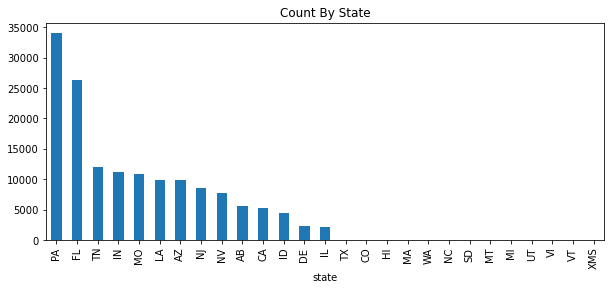

In [22]:
fig, ax = plt.subplots(figsize=(10, 4))
business_pandas.value_counts('state').plot(kind = 'bar')
plt.title('Count By State')
plt.show()

### Number of businesses in each city.

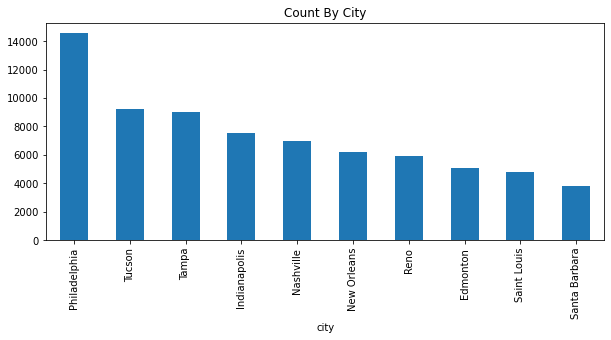

In [23]:
fig, ax = plt.subplots(figsize=(10, 4))
business_pandas.value_counts('city')[:10].plot(kind = 'bar')
plt.title('Count By City')
plt.show()

### Number of businesses in each category.

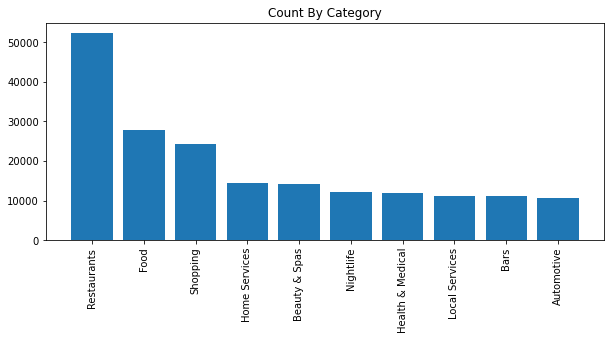

In [24]:
category_counts = business_df.withColumn('category', explode(split('categories', ', '))).groupBy('category').count().orderBy('count', ascending=False)
category_counts_pandas = category_counts.toPandas()
top_10_category = category_counts_pandas[:10]

fig, ax = plt.subplots(figsize=(10, 4))
plt.bar(top_10_category['category'],top_10_category['count'])
plt.title('Count By Category')
plt.xticks(rotation = 90)
plt.show()

In [ ]:
review_sampled_df = review_df.sample(withReplacement = False, fraction = 0.25, seed = 505)
review_sampled_df.count()

In [ ]:
review_pandas = ps.DataFrame(review_sampled_df)
review_pandas.head(10)

### Dsitribution of stars of all reviews

In [ ]:
review_pandas.groupby('stars')['business_id'].count().sort_index(ascending=False).plot(kind='bar',labels={'value':'count'})

### Distribution of attributes 'cool', 'funny' and 'useful'

In [ ]:
review_cool_sum = review_pandas['cool'].sum()
review_funny_sum = review_pandas['funny'].sum()
review_useful_sum = review_pandas['useful'].sum()
review_attribute_pandas = ps.DataFrame({'lab': ['cool', 'funny', 'useful'], 'val': [review_cool_sum, review_funny_sum, review_useful_sum]})
review_attribute_pandas.plot.bar(x='lab', y='val', labels={'lab':'attribute','val':'count'})  

In [ ]:
user_sampled_df = user_df.sample(withReplacement = False, fraction = 0.25, seed = 505)
user_sampled_df.count()

In [ ]:
user_pandas = ps.DataFrame(user_sampled_df)
user_pandas.head(10)

### Correlation between star rating and attributes

In [ ]:
user_pandas.plot.scatter(x='average_stars', y='cool')

In [ ]:
user_pandas.plot.scatter(x='average_stars', y='funny')

In [ ]:
user_pandas.plot.scatter(x='average_stars', y='useful')

In [ ]:
user_pandas.plot.scatter(x='user_id', y='review_count')

### Number of reviews by each user

In [ ]:
user_pandas.plot.scatter(x='user_id', y='review_count')

### Number of reviews by each user with no outliers

In [ ]:
user_pandas_outliers = user_pandas[user_pandas['review_count'] <= 2500]
user_pandas_outliers.plot.scatter(x='user_id', y='review_count')

### Number of users with no reviews

In [ ]:
user_pandas_review = user_pandas['review_count'].where(user_pandas.review_count >= 1).count()
user_pandas_no_review = user_pandas['review_count'].where(user_pandas.review_count == 0).count()
user_review_pandas = ps.DataFrame({'lab': ['>1 reviews', '0 reviews'], 'val': [user_pandas_review, user_pandas_no_review]})
user_review_pandas.plot.bar(x='lab', y='val', labels={'lab':'Review count','val':'User count'})
print('Number of users with no reviews: ', user_pandas_no_review)